In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import os
import json
import sys
import numpy as np
sys.path.append("..")
import copy
from tqdm.auto import tqdm

In [3]:
from src import models, data, operators, utils, functional, metrics, lens
from src.utils import logging_utils, experiment_utils
import logging
import torch
import baukit

experiment_utils.set_seed(123456)

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.INFO,
    format = logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout
)

In [4]:
from scripts.interpolation import save_order_1_approx, normalize_on_sphere

### Interpolation Experiment

In [5]:
mt = models.load_model(name = "gptj", fp16 = True, device = "cuda")

2023-08-10 12:25:21 src.models INFO     loading EleutherAI/gpt-j-6B (device=cuda, fp16=True)
2023-08-10 12:25:30 src.models INFO     dtype: torch.float16, device: cuda:0, memory: 12219206136


In [113]:
relation_name = "name birthplace"
relation = data.load_dataset().filter(relation_names=[relation_name])[0]

In [114]:
def load_cached_values(trial_path, idx):
    approx = np.load(f"{trial_path}/approx_{idx+1}.npz", allow_pickle=True)
    approx_dict = {}
    for key,value in approx.items():
        if key in ["h", "z", "weight", "bias"]:
            approx_dict[key] = torch.from_numpy(value).cuda()
        else:
            approx_dict[key] = value
    weight = torch.Tensor(approx['weight']).cuda()
    h = torch.Tensor(approx['h']).cuda()
    z = torch.Tensor(approx['z']).cuda()

    return weight, h, z, approx

In [115]:
from src.operators import JacobianIclMeanEstimator

In [116]:
def execute_line_integral_experiment(trial_path, interpolation_steps, lre_W = None, h_layer = None):
    jacobians, hs, zs = [], [], []
    for idx in tqdm(range(interpolation_steps)):
        j, h, z, approx  = load_cached_values(trial_path, idx)
        jacobians.append(j)
        hs.append(h)
        zs.append(z)

        if h_layer is None:
            h_layer = approx["h_layer"].item()
    
    u = zs[-1] - zs[0]
    v = hs[-1] - hs[0]
    u /= u.norm()
    v /= v.norm()

    dh = (hs[-1] - hs[0])/interpolation_steps

    scalar_values = []
    Dz = zs[-1] - zs[0]
    Dz_approx = 0
    for dF in jacobians:
        s = u[None] @ dF @ v[None].T
        scalar_values.append(s.item())
        Dz_approx += s * dh

    if lre_W is None:
        estimator = JacobianIclMeanEstimator(mt = mt, h_layer=h_layer)
        train, test = relation.split(train_size=5)
        operator = estimator(train)
        lre_W = operator.weight.float()

    Dz_lre = (u[None] @ lre_W @ v[None].T) * (hs[-1] - hs[0]).norm()

    return Dz.norm().item(), Dz_approx.norm().item(), Dz_lre.norm().item(), scalar_values

2023-08-10 14:21:12 src.utils.experiment_utils INFO     setting all seeds to 123456
Xia-Yitzhak


  0%|          | 0/100 [00:00<?, ?it/s]

True Dz: 103.6745 | Approx Dz: 91.3328 | LRE Dz: 26.3353
Anong-Pierre


  0%|          | 0/100 [00:00<?, ?it/s]

True Dz: 106.8644 | Approx Dz: 88.1076 | LRE Dz: 18.5963
Chalermchai-Arjun


  0%|          | 0/100 [00:00<?, ?it/s]

True Dz: 63.3901 | Approx Dz: 57.1723 | LRE Dz: 10.9721
Antoine-Alejandro


  0%|          | 0/100 [00:00<?, ?it/s]

True Dz: 89.7134 | Approx Dz: 83.2583 | LRE Dz: 18.6049
Chawalit-Arjun


  0%|          | 0/100 [00:00<?, ?it/s]

True Dz: 110.1415 | Approx Dz: 94.3721 | LRE Dz: 15.3415
Mei-Yitzhak


  0%|          | 0/100 [00:00<?, ?it/s]

True Dz: 100.9909 | Approx Dz: 87.5100 | LRE Dz: 20.5287
Juan-Akira


  0%|          | 0/100 [00:00<?, ?it/s]

True Dz: 100.0297 | Approx Dz: 90.0165 | LRE Dz: 24.9157
Carlo-Tal


  0%|          | 0/100 [00:00<?, ?it/s]

True Dz: 72.8613 | Approx Dz: 64.6091 | LRE Dz: 21.5102
Yitzhak-Antoine


  0%|          | 0/100 [00:00<?, ?it/s]

True Dz: 101.2108 | Approx Dz: 91.3635 | LRE Dz: 18.1259
Giovanni-Chalermchai


  0%|          | 0/100 [00:00<?, ?it/s]

True Dz: 110.3527 | Approx Dz: 92.4334 | LRE Dz: 27.8728


Text(0, 0.5, "$u^T \\times F^'(s) \\times v$")

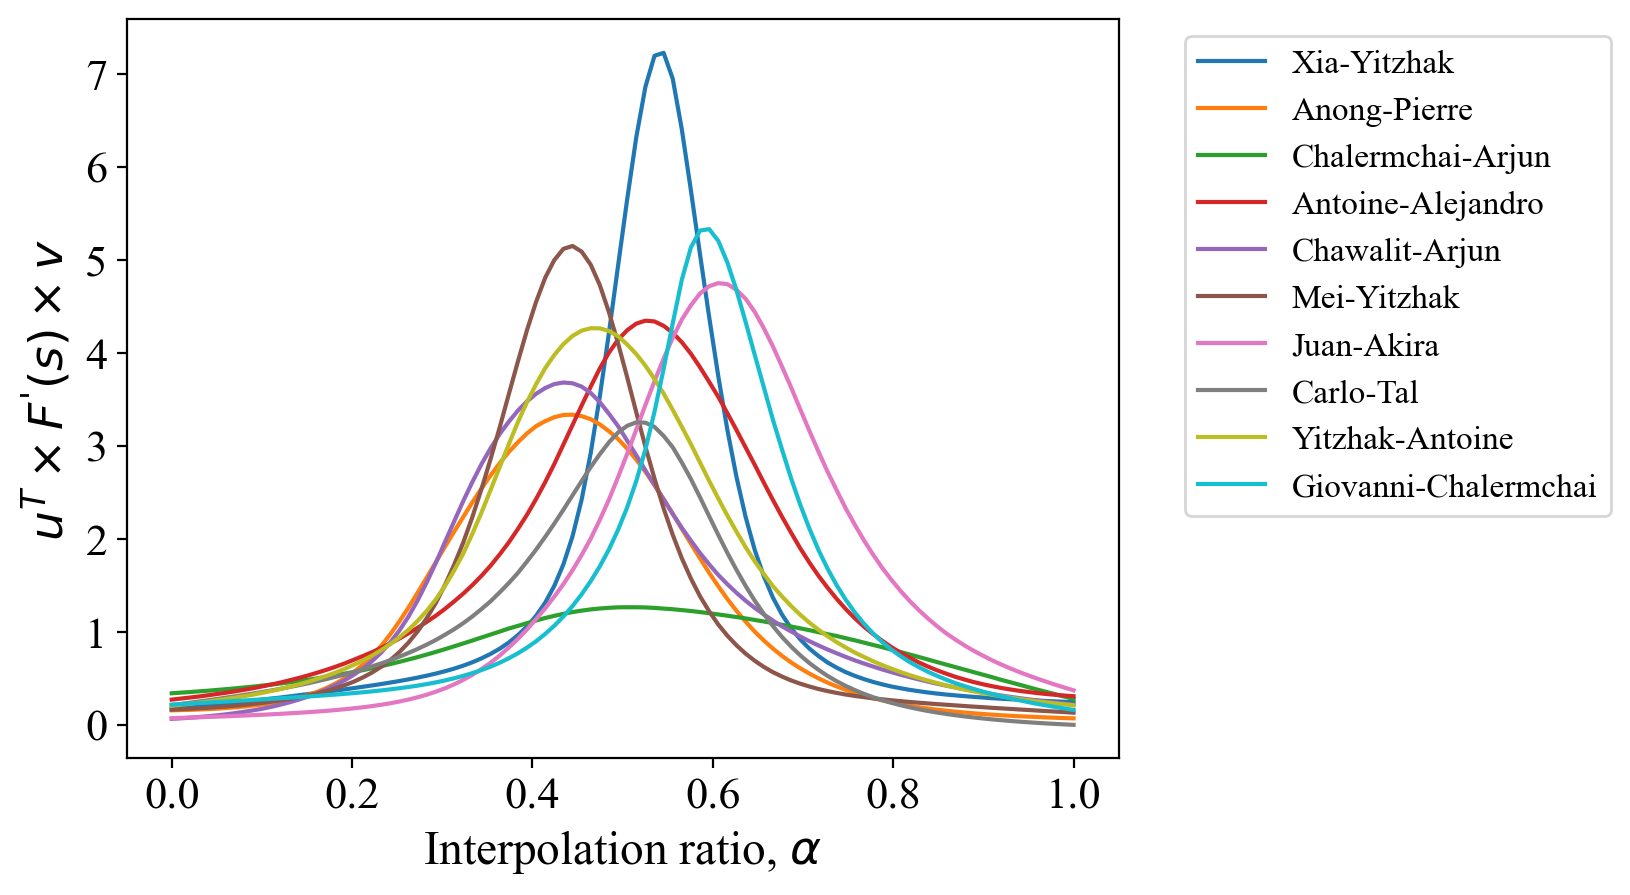

In [117]:
# s1, s2 = "Brazil", "Spain"


experiment_utils.set_seed(123456)

path = f"../results/interpolation/{relation_name}/"
trials = os.listdir(path)

actual_delta_zs = []
approx_delta_zs = []
lre_delta_zs = []
scalar_values = []

for trial in trials: #[f"{s1}-{s2}"]:
    print(trial)
    trial_path = os.path.join(path, trial)
    interpolation_steps = len(os.listdir(trial_path))
    Dz, Dz_approx, Dz_lre, values_i = execute_line_integral_experiment(trial_path, interpolation_steps)

    actual_delta_zs.append(Dz)
    approx_delta_zs.append(Dz_approx)
    lre_delta_zs.append(Dz_lre)
    scalar_values.append(values_i)

    plt.plot(np.linspace(0, 1, interpolation_steps), values_i, label=trial)
    print(f"True Dz: {Dz:.4f} | Approx Dz: {Dz_approx:.4f} | LRE Dz: {Dz_lre:.4f}")


plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Interpolation ratio, $\\alpha$")
plt.ylabel(r"$u^T \times F^'(s) \times v$")

In [118]:
beta = torch.Tensor(approx_delta_zs)/torch.Tensor(lre_delta_zs)
f"beta: {beta.mean():.3f}+/-{beta.std():.3f}"

'beta: 4.328+/-0.991'

In [111]:
fig_dir = "figures/figs"
#####################################################################################
plt.rcdefaults()
color = "purple"
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", labelsize=MEDIUM_SIZE+1)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=50)  # fontsize of the figure title
#####################################################################################

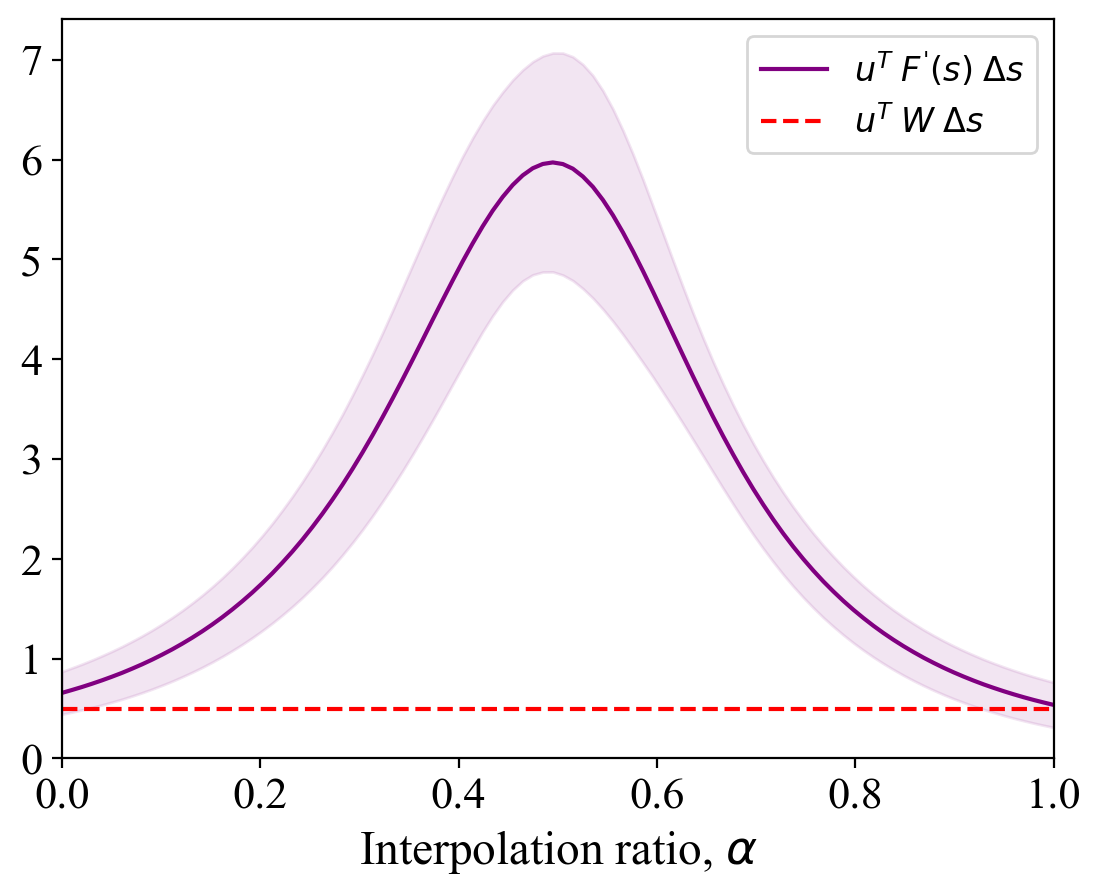

In [112]:
scalar_values_mean = torch.Tensor(scalar_values).mean(dim=0)
scalar_values_std = torch.Tensor(scalar_values).std(dim=0)

lre_delta_mean = torch.Tensor(lre_delta_zs).mean()
lre_delta_std = torch.Tensor(lre_delta_zs).std()

plt.plot(np.linspace(0, 1, interpolation_steps), scalar_values_mean, color="purple", label = r"$u^T \; F^'(s) \; \Delta s$")
plt.fill_between(np.linspace(0, 1, interpolation_steps), scalar_values_mean - scalar_values_std, scalar_values_mean + scalar_values_std, color="purple", alpha=0.1)
plt.axhline(y=lre_delta_mean/100, color='r', linestyle='--', label=r"$u^T \; W \; \Delta s$")

plt.legend()
plt.xlabel("Interpolation ratio, $\\alpha$")
plt.xlim(0, 1)
plt.ylim(bottom=0)

plt.savefig(f"{fig_dir}/line_integration.pdf", bbox_inches="tight")

In [93]:
from src.utils.sweep_utils import read_sweep_results, relation_from_dict

sweep_path = f"../results/sweep-24-trials/gptj"
relation_result_raw = read_sweep_results(
    sweep_path, relation_names=[relation_name], economy=True
)[relation_name]
relation_result = relation_from_dict(relation_result_raw)

2023-08-10 13:57:24 src.utils.sweep_utils ERROR    ERROR reading ../results/sweep-24-trials/gptj/plays_pro_sport/3_plays_pro_sport_seed_709106/plays_pro_sport.json: Expecting property name enclosed in double quotes: line 4534577 column 16 (char 242065218)


In [94]:
relation_result.best_by_efficacy()

SweepLayerSummary(layer=6, beta=AggregateMetric(mean=2.4375, stdev=0.5484352742120077, stderr=0.13710881855300192, values=[2.5, 2.5, 2.5, 3.0, 3.0, 1.75, 2.25, 2.5, 3.5, 2.0, 3.0, 1.75, 2.5, 2.25, 1.25, 2.75]), recall=AggregateMetric(mean=0.7604823303913877, stdev=0.050609421067344944, stderr=0.012652355266836236, values=[0.7760617760617761, 0.8024691358024691, 0.694560669456067, 0.8114754098360656, 0.6769911504424779, 0.7647058823529411, 0.7239819004524887, 0.7528089887640449, 0.7375, 0.7176470588235294, 0.6666666666666666, 0.8326693227091634, 0.7958333333333333, 0.8, 0.8, 0.8143459915611815]), rank=AggregateMetric(mean=135.5, stdev=64.52712607888252, stderr=16.13178151972063, values=[72, 112, 72, 216, 216, 112, 112, 224, 208, 80, 136, 72, 144, 256, 64, 72]), efficacy=AggregateMetric(mean=0.9399655378230654, stdev=0.01198007815057308, stderr=0.00299501953764327, values=[0.9343629343629344, 0.9259259259259259, 0.9497907949790795, 0.9344262295081968, 0.9557522123893806, 0.92941176470588

### Loading Cached $\mathcal{W}$ and $b$

In [ ]:
# relation = data.load_dataset().filter(relation_names=["country capital city"])[0].set(prompt_templates=[" {}:"])
# train, test = relation.split(5)

# #################################################
# h_layer = 8
# beta = 2.25
# interpolation_steps = 100
# #################################################

# mt = models.load_model(name = "gptj", fp16 = True, device = "cuda")

In [140]:
# path = "../results/interpolation/country capital city/"
# W_norms = []
# B_norms = []
# Jh_norms = []
# J_delta_h = []

# values = []
# labels = []


# for trial in os.listdir(path):
#     # if(trial == "Colombia-Venezuela"):
#     #     continue
#     if(trial != f"{s1}-{s2}"):
#         continue

#     s1, s2 = trial.split("-")
#     hs_and_zs = functional.compute_hs_and_zs(
#         mt = mt,
#         prompt_template = train.prompt_templates[0],
#         subjects = list(set([sample.subject for sample in relation.samples] + [s1, s2])),
#         h_layer= h_layer,
#         z_layer=-1,
#         examples= train.samples
#     )
#     h1, h2 = [hs_and_zs.h_by_subj[s] for s in [s1, s2]]
#     z1, z2 = [hs_and_zs.z_by_subj[s] for s in [s1, s2]]

#     do = (z2 - z1).float()
#     ds = (h2 - h1).float()

#     trial_path = os.path.join(path, trial)
#     approxes = []
#     interpolation_steps = len(os.listdir(trial_path))
#     for idx in tqdm(range(interpolation_steps)):
#         approx = np.load(f"{trial_path}/approx_{idx+1}.npz", allow_pickle=True)
#         approx_dict = {}
#         for key,value in approx.items():
#             if key in ["h", "z", "weight", "bias"]:
#                 approx_dict[key] = torch.from_numpy(value).cuda()
#             else:
#                 approx_dict[key] = value
#         approxes.append(approx_dict)

#     for a in approxes:
#         weight = torch.Tensor(a['weight']).float().cuda()

#         # scalar_value = torch.cosine_similarity(weight @ ds, do, dim = -1)
#         # scalar_value = torch.dot(weight @ ds, do)
#         # G = torch.tensor([torch.dot(do, weight[i]) for i in range(models.determine_hidden_size(mt))]).cuda()
#         # scalar_value = torch.dot(G, ds)
#         scalar_value = do[None] @ (weight @ ds[None].T)
#         values.append(scalar_value.item())



#     # w_norms = [torch.Tensor(a['weight']).norm().item() for a in approxes]
#     # b_norms = [torch.Tensor(a['bias']).norm().item() for a in approxes]
#     # jh_norms = [torch.Tensor(a["metadata"].item()["Jh"]).norm().item() for a in approxes]

#     # h1 = normalize_on_sphere(approxes[0]['h'], scale=60.0)
#     # h2 = normalize_on_sphere(approxes[-1]['h'], scale=60.0)
#     # delta_h = normalize_on_sphere(h2 - h1, scale=60.0)
#     # # delta_h = hs_and_zs.h_by_subj["Russia"]
#     # j_delta_h = [(torch.Tensor(a['weight']) @ delta_h).norm().item() for a in approxes]

#     # W_norms.append(w_norms)
#     # B_norms.append(b_norms)
#     # Jh_norms.append(jh_norms)
#     # J_delta_h.append(j_delta_h)
#     # labels.append(trial)

Mexico-Chile


  0%|          | 0/100 [00:00<?, ?it/s]

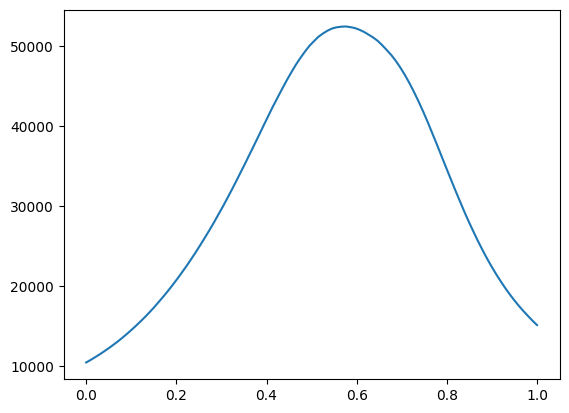

In [142]:
# plt.rcdefaults()

# plt.plot(np.linspace(0, 1, interpolation_steps), values)

Text(0, 0.5, '|| $W$ ||')

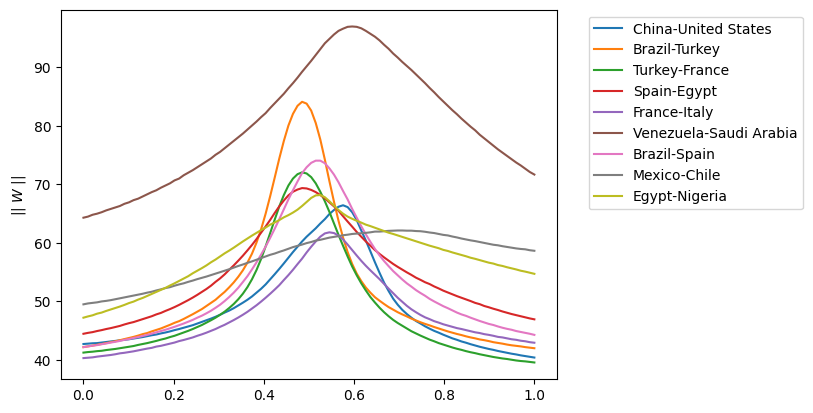

In [26]:
# plt.rcdefaults()

# for trial, label in zip(W_norms, labels):
#     plt.plot(np.linspace(0, 1, interpolation_steps), trial, label=label)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.ylabel("|| $W$ ||")

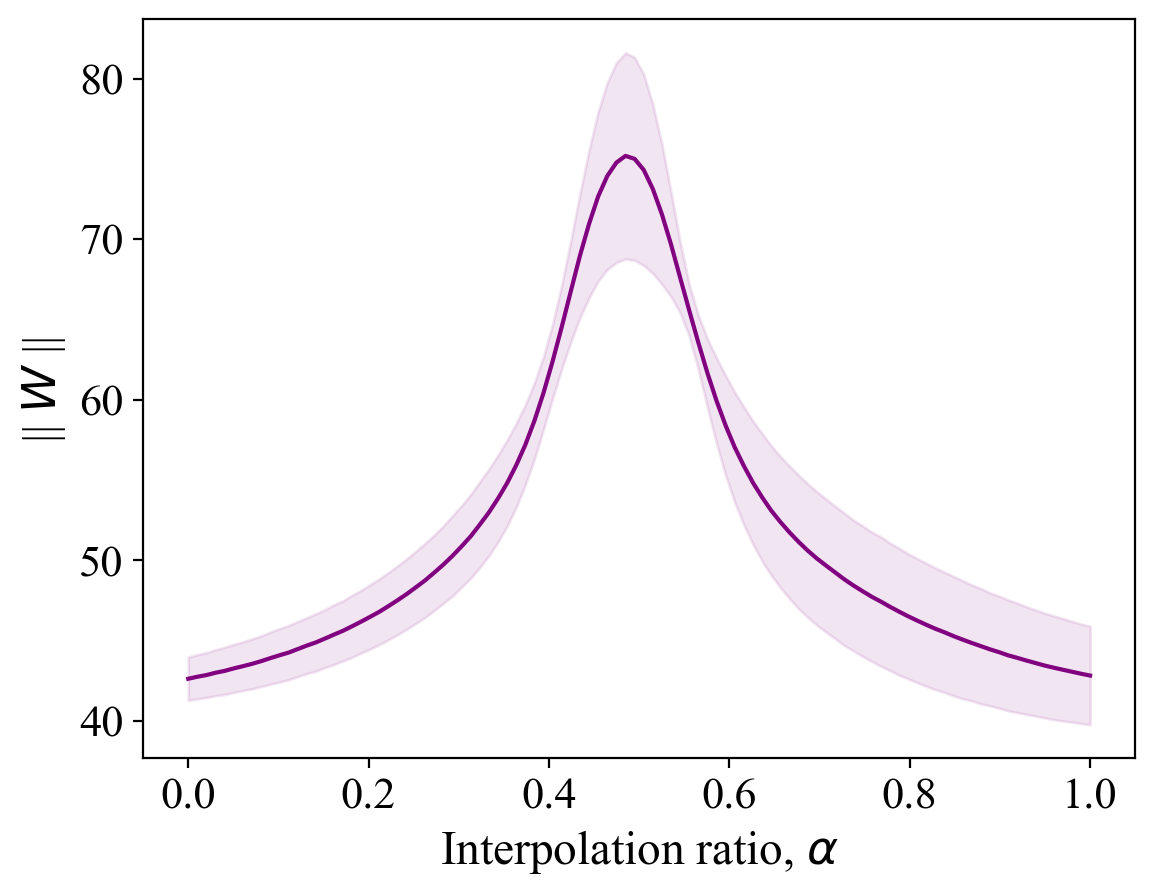

In [28]:
# # filter_trials = ["South Korea-Brazil", "Brazil-Nigeria", "Egypt-South Korea", "Chile-Egypt"]
# filter_trials = ["Brazil-Turkey", "Turkey-France", "Brazil-France", "Spain-Egypt"]
# trial_results = []
# for trial, label in zip(W_norms, labels):
#     if label not in filter_trials:
#         continue
#     trial_results.append(trial)
#     # plt.plot(np.linspace(0, 1, interpolation_steps), trial, label=label)
# # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# trial_results = np.array(trial_results)
# trial_results_mean = trial_results.mean(axis=0)
# trial_results_std = trial_results.std(axis=0)


# fig_dir = "figures/figs"
# #####################################################################################
# plt.rcdefaults()
# color = "purple"
# plt.rcParams["figure.dpi"] = 200
# plt.rcParams["font.family"] = "Times New Roman"

# SMALL_SIZE = 12
# MEDIUM_SIZE = 16
# BIGGER_SIZE = 18

# plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
# plt.rc("axes", labelsize=MEDIUM_SIZE+1)  # fontsize of the x and y labels
# plt.rc("xtick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
# plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
# plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
# plt.rc("figure", titlesize=50)  # fontsize of the figure title
# #####################################################################################

# x = np.linspace(0, 1, interpolation_steps)
# plt.plot(x, trial_results_mean, color=color)
# plt.fill_between(x, trial_results_mean - trial_results_std, trial_results_mean + trial_results_std, alpha=0.1, color = color)
# plt.xlabel("Interpolation ratio, $\\alpha$")
# plt.ylabel("|| $W$ ||")

# plt.savefig(f"{fig_dir}/j_underestimation.pdf", bbox_inches="tight")

Text(0, 0.5, '|| $W @ \\Delta h$ ||')

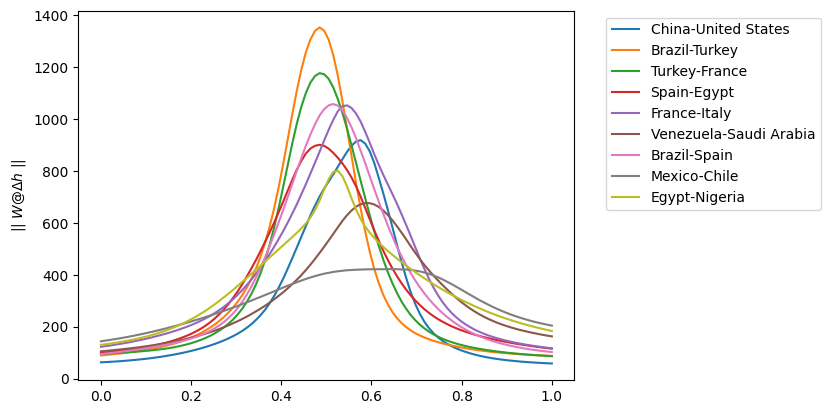

In [29]:
# # J(h2 - h1)
# plt.rcdefaults()
# for trial, label in zip(J_delta_h, labels):
#     plt.plot(np.linspace(0, 1, interpolation_steps), trial, label=label)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.ylabel("|| $W @ \Delta h$ ||")

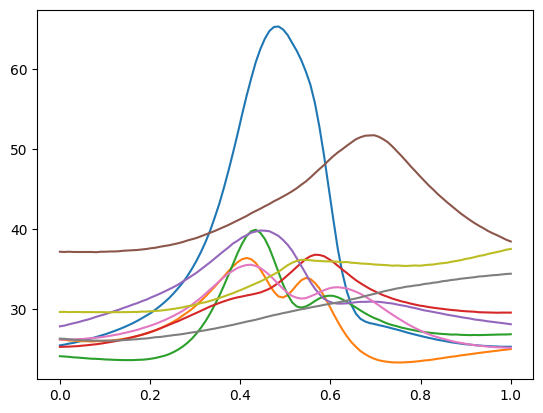

In [30]:
# for trial in Jh_norms:
#     plt.plot(np.linspace(0, 1, interpolation_steps), trial)